/tmp/ipykernel_2691964/2750815654.py:103: RuntimeWarning: invalid value encountered in divide
  rel_diff = np.where(valid_for_rel_diff, np.abs(netcdf_values_masked - zarr_values_masked) / np.abs(netcdf_values_masked), np.nan)


Absolute Difference - Mean: 0.0, Median: 0.0, Std: 0.0
Relative Difference - Mean: 0.0, Median: 0.0, Std: 0.0


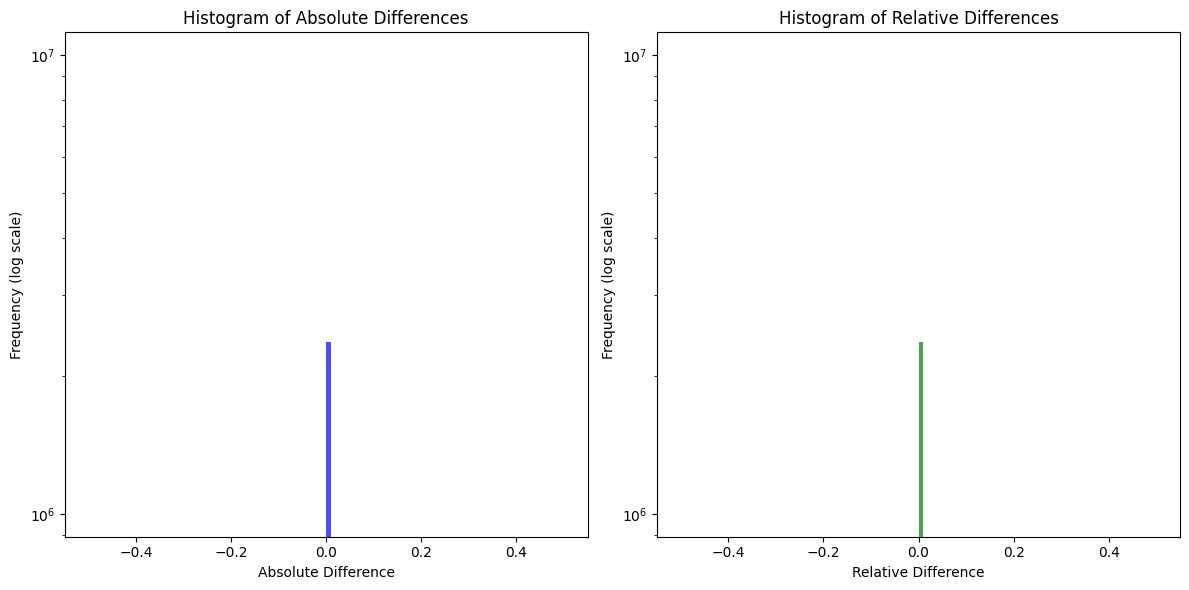

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

parameters = {
    't': 'temperature',
    's': 'salinity',
    'o': 'oxygen',
    'O': 'o2sat',
    'A': 'AOU',
    'i': 'silicate',
    'p': 'phosphate',
    'n': 'nitrate'
}
time_periods = {
    '0': 'annual',
    '1': 'january',
    '2': 'february',
    '3': 'march',
    '4': 'april',
    '5': 'may',
    '6': 'june',
    '7': 'july',
    '8': 'august',
    '9': 'september',
    '10': 'october',
    '11': 'november',
    '12': 'december',
    '13': 'winter',
    '14': 'spring',
    '15': 'summer',
    '16': 'autumn'
}
subgroup_definitions = {
    'TS': ['temperature', 'salinity'],
    'Oxy': ['oxygen', 'o2sat', 'AOU'],
    'Nutrients': ['nitrate', 'phosphate', 'silicate']
}

# Function to determine the subgroup
def determine_subgroup(param, period):
    param_name = parameters[param]
    param_group = 'Nutrients'

    if param_name in ['temperature', 'salinity']:
        param_group = 'TS'
    elif param_name in ['oxygen', 'o2sat', 'AOU']:
        param_group = 'Oxy'
    
    if period == '0':
        subgroup = f'annual/{param_group}'
    elif period in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']:
        subgroup = f'monthly/{param_group}'
    else:
        subgroup = f'seasonal/{param_group}'    

    return subgroup

# Load Zarr data
data_dir = '../data'
grid_res = '01' #'04'
grid_dir = {'04': '025_degree', '01': '1_degree'}
param_key = 's'
period_key = '16'
padded_period = period_key.zfill(2)
span = 'decav' if param_key in ['t', 's'] else 'all'

# Load NetCDF data
netcdf_file = f"../tmp_data/woa23_{span}_{param_key}{padded_period}_{grid_res}.nc"
nc_ds = xr.open_dataset(netcdf_file, decode_times=False)

subgroup = determine_subgroup(param_key, period_key)
datax = f'{data_dir}/{grid_dir[grid_res]}/{subgroup}'
zarr_ds = xr.open_zarr(datax, consolidated=False)

# Select temperature data
param = parameters[param_key]
time_period = period_key

# Ensure the parameters and time periods exist
if param in zarr_ds.parameters.values and time_period in zarr_ds.time_periods.values:
    # Extract data
    netcdf_data = nc_ds[f"{param_key}_mn"] # Assuming 't_an' is the temperature variable in NetCDF
    zarr_data = zarr_ds.sel(parameters=param, time_periods=time_period)['mn']

    # Mask NaN values
    netcdf_values = netcdf_data.values.squeeze()
    zarr_values = zarr_data.values

    # Create a mask for non-NaN values in both NetCDF and Zarr datasets
    valid_mask = np.isfinite(netcdf_values) & np.isfinite(zarr_values)

    # Apply the mask to both datasets
    netcdf_values_masked = np.where(valid_mask, netcdf_values, np.nan)
    zarr_values_masked = np.where(valid_mask, zarr_values, np.nan)

    # Filter small values for relative difference calculation
    small_value_threshold = 1e-3
    valid_for_rel_diff = valid_mask & (np.abs(netcdf_values_masked) > small_value_threshold)

    # Calculate absolute and relative differences
    abs_diff = np.abs(netcdf_values_masked - zarr_values_masked)
    rel_diff = np.where(valid_for_rel_diff, np.abs(netcdf_values_masked - zarr_values_masked) / np.abs(netcdf_values_masked), np.nan)

    # Identify indices with differences
    diff_mask = (netcdf_values_masked != zarr_values_masked) & valid_mask
    diff_indices = np.where(diff_mask)

    # Print differences
    if np.any(diff_mask):
        print("Differences found at indices:", diff_indices)
        for idx in range(min(10, len(diff_indices[0]))):  # Only show the first 10 differences
            d, la, lo = diff_indices[0][idx], diff_indices[1][idx], diff_indices[2][idx]
            print(f"Index (depth: {d}, lat: {la}, lon: {lo}) - NetCDF value: {netcdf_values[d, la, lo]}, Zarr value: {zarr_values[d, la, lo]}")

    # Compute statistics
    mean_abs_diff = np.nanmean(abs_diff)
    median_abs_diff = np.nanmedian(abs_diff)
    std_abs_diff = np.nanstd(abs_diff)

    mean_rel_diff = np.nanmean(rel_diff)
    median_rel_diff = np.nanmedian(rel_diff)
    std_rel_diff = np.nanstd(rel_diff)

    print(f"Absolute Difference - Mean: {mean_abs_diff}, Median: {median_abs_diff}, Std: {std_abs_diff}")
    print(f"Relative Difference - Mean: {mean_rel_diff}, Median: {median_rel_diff}, Std: {std_rel_diff}")

    # Visualize the differences
    plt.figure(figsize=(12, 6))

    # Plot absolute differences
    plt.subplot(1, 2, 1)
    plt.hist(abs_diff[valid_mask].flatten(), bins=100, color='blue', alpha=0.7, log=True)
    plt.title('Histogram of Absolute Differences')
    plt.xlabel('Absolute Difference')
    plt.ylabel('Frequency (log scale)')

    # Plot relative differences
    plt.subplot(1, 2, 2)
    plt.hist(rel_diff[valid_for_rel_diff].flatten(), bins=100, color='green', alpha=0.7, log=True)
    plt.title('Histogram of Relative Differences')
    plt.xlabel('Relative Difference')
    plt.ylabel('Frequency (log scale)')

    plt.tight_layout()
    plt.show()
else:
    print("Parameter or time period not found in the Zarr dataset.")
